In [23]:
import os
import pandas as pd
import re
from IPython.display import display, HTML
import spacy
import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


##for clustering
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize

##To download packages directly from jupyter notebook
import sys ##execute the pip installs if you are running this for the first time

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sdeshpande/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sdeshpande/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [1]:
import os
import pandas as pd 
import xml.etree.ElementTree as et 

In [3]:
path = '/Users/sdeshpande/Desktop/bioinformatices/Clinical_notes/train/'
df_cols = ['clinical_notes']
rows = []

for filename in os.listdir(path):
    if filename.endswith('.xml'):
        fullname = os.path.join(path, filename)
        xtree = et.parse(fullname)
        xroot = xtree.getroot()
        note = xroot.find('TEXT').text          
        rows.append(note)                    

In [6]:
final_notes = []
for n in rows:
    temp = n.split("****************************************************************************************************")
    for s in temp:
        final_notes.append(s)

In [9]:
df = pd.DataFrame({'clinical_notes':final_notes})

In [19]:
df['clinical_notes'] = df['clinical_notes'].str.replace("                     ", " ")
df['clinical_notes'] = df['clinical_notes'].str.replace("                    ", " ")
df.head()

,clinical_notes
0,Record date: 2068-02-04\n\nASSOCIATED ARTHRITI...
1,Record date: 2074-01-22\n\n AASC EMERGENCY DEP...
2,Record date: 2075-01-15\n\n AASC EMERGENCY DEP...
3,Record date: 2076-07-20\n\n Pati...
4,Record date: 2077-02-05\n\n AASC EMERGENCY DEP...


In [28]:
def clean_text(x):
    x = " ".join(x.split())
    x= " ".join((" ".join(x.split("[**"))).split("**]"))
    x = re.sub(r"\([^()]*\)", "", x)
    key_value_strip =(x.split(":"))
    ##remove all sub strings which have a length lesser than 50 characters
    string = " ".join([sub_unit for sub_unit in key_value_strip if len(sub_unit)>50])
    x = re.sub(r"(\d+)+(\.|\))", "", string)## remove all serialization eg 1. 1)
    x = re.sub(r"(\*|\?|=)+", "", x) ##removing all *, ? and =
    x = re.sub(r"\b(\w+)( \1\b)+", r"\1", x) ## removing consecutive dupicate words
    x = x.replace("FOLLOW UP", "FOLLOWUP")
    x = x.replace("FOLLOW-UP", "FOLLOWUP")
    x = re.sub(r"(\b)(f|F)(irst)(\b)?[\d\-\d]*(\s)*(\b)?(n|N)(ame)[\d\-\d]*(\s)*[\d\-\d]*(\b)","",x)##remove firstname
    x = re.sub(r"(\b)(l|L)(ast)(\b)?[\d\-\d]*(\s)*(\b)?(n|N)(ame)[\d\-\d]*(\s)*[\d\-\d]*(\b)", "", x)
    x = re.sub(r"(\b)(d|D)\.?(r|R)\.?(\b)", "", x) #remove Dr abreviation
    x = re.sub(r"([^A-Za-z0-9\s](\s)){2,}", "", x)##remove consecutive punctuations
    x = re.sub(r"______________________________","",x)
    

    return(x.replace("  ", " "))

In [29]:
df['clinical_notes'] = df['clinical_notes'].apply(lambda x: clean_text(x))

In [32]:
topics = df['clinical_notes'].apply(lambda text:list(filter(None,[x.strip() for x in re.findall(r"\b[A-Z\s]+\b",text)])))
topics = topics.tolist() 
#combine all items from topics and find unique elements 
topics = sorted(set([sub_topic.strip() for topic in topics for sub_topic in topic]))
print("Number of unique topics identified: ",len(topics))

Number of unique topics identified:  4854


In [34]:
##We remove all words from the topics list which had a high potential to be an acronym
topics = [topic for topic in topics if (len(topic.split())>2) or (len(topic.split())<2 and len(topic)>4)]
print("Unique Eligible topics: ", len(topics))
pd.DataFrame(topics, columns=['topics']).to_csv("/Users/sdeshpande/Desktop/bioinformatices/Clinical_notes/potential_topics.csv", index = False)

Unique Eligible topics:  1898


In [36]:
topics = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/Clinical_notes/potential_topics.csv")
print(topics.shape)
topics= topics["topics"].tolist()
print(topics)

(1898, 1)
['A ANISO HYPO', 'A COMPLEX CHD NORM EF', 'A FULL CODE', 'A LEFT VENT', 'A LVOT ABN AO', 'A LVOT NORM AO', 'A MEDICATIONS MVI', 'A NODULAR OPACITY IN THE RIGHT UPPER LUNG ZONE IS NOW BETTER DEFINED THAN IN THE PREVIOUS EXAMINATION', 'A PET CT', 'A RADIOLOGICAL STUDIES CXR', 'AASC EMERGENCY DEPT VISIT QUIJANO', 'ABASO', 'ABASOP', 'ABDOMEN', 'ACCESS', 'ACE PMH HTN', 'ACETAMINOPHEN', 'ACETYLSALICYLIC', 'ACTION', 'ACUTE RENAL FAILURE DIAGNOSIS MRA', 'ADAIR', 'ADDENDUM', 'ADVERSE DRUG RXN', 'ADVERSE REACTIONS IV', 'ADVERSE REACTIONS NKDA FAMILY HISTORY', 'AEOSN', 'AFFINITY', 'AFFINITY OTHER HEMOGLOBINOPATHY', 'AFTER', 'AFVSS', 'AH EMERGENCY DEPT VISIT BRANCH', 'ALB GLOB LDH', 'ALB GLOB LIPS', 'ALB NEGATIVE UA', 'ALB TP ALKP DBILI TBILI ALT', 'ALB TP ALKP TBILI ALT', 'ALBERT', 'ALBUMIN', 'ALBUTEROL', 'ALCOHOL', 'ALH CARDIAC ULTRASOUND', 'ALL AVSS NAD', 'ALLERGIES', 'ALLERGIES NIFEDIPINE SR', 'ALLERGIES NKDA FAMILY HISTORY', 'ALLERGIES NKDA PHYSICAL EXAM', 'ALLERGIES NKDA PHYSICAL E

In [37]:
nlp = en_core_web_lg.load()
stemmer = SnowballStemmer(language='english')

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [38]:
lemmatized_topics_values =[]
lemmatized_topics_index = []
index = 0

for doc in nlp.pipe(topics):
##         Confirming that lemmatization is working as expected
#     for token in doc:
#         if token.text.lower()!= token.lemma_.lower():
#             print(token.text, token.lemma_)
    lemmatized_topics_values.append(' '.join(
                                [token.lemma_.strip().lower() for token in doc if not nlp.vocab[token.text].is_stop]
                                            ).strip().upper())
    lemmatized_topics_index.append(stemmer.stem(lemmatized_topics_values[index].lower()))
    index +=1

In [39]:
for index in range(len(lemmatized_topics_index)):
    print("Original Topic: %s \n New Topic Index: %s\n New Topic value: %s"%(topics[index], 
                                                                             lemmatized_topics_index[index],
                                                                             lemmatized_topics_values[index]))
    ##you can remove this to see all pairs
    if index>2:
        break
    print("\n\n")

Original Topic: A ANISO HYPO 
 New Topic Index: aniso hypo
 New Topic value: ANISO HYPO



Original Topic: A COMPLEX CHD NORM EF 
 New Topic Index: complex chd norm ef
 New Topic value: COMPLEX CHD NORM EF



Original Topic: A FULL CODE 
 New Topic Index: code
 New Topic value: CODE



Original Topic: A LEFT VENT 
 New Topic Index: left vent
 New Topic value: LEFT VENT


In [41]:
def toLower(text):
    matches = re.findall(r"\b[A-Z\s]+\b",text)
    non_matches = re.split(r"\b[A-Z\s]+\b",text) ## see what happens with re.split(r"\b[A-Z\s]+\b",text)
#     print((non_matches))
    for index, match in enumerate(matches):
        if match.strip() == '' or match.strip() == ' ':
            matches[index] = non_matches[index]
        elif len(match.split())>1: ## look for stop word only if the possible topic has more than 1 word
            match_cleaned = ' '.join(
                            [word for word in match.lower().strip().split() if not nlp.vocab[word.lower()].is_stop]
                                    )
            doc = nlp(match_cleaned)
            match_cleaned = ' '.join([token.lemma_ for token in doc])          
            if stemmer.stem(match_cleaned.strip()) in lemmatized_topics_index:
                matches[index] = lemmatized_topics_values[lemmatized_topics_index.index(
                                                                                stemmer.stem(match_cleaned.strip())
                                                                                        )
                                                         ]
            else:
                matches[index] = match.lower()
        elif len(match.split())==1:
            match_cleaned = match.lower().strip()
            doc = nlp(match_cleaned)
            match_cleaned = ' '.join([token.lemma_ for token in doc])          
            if stemmer.stem(match_cleaned.strip()) in lemmatized_topics_index:
                matches[index] = lemmatized_topics_values[lemmatized_topics_index.index(
                                                                                stemmer.stem(match_cleaned.strip())
                                                                                        )
                                                         ]
            else:
                matches[index] = match.lower()
    return(' '.join(matches))

In [42]:
df['clinical_notes'] = df['clinical_notes'].apply(lambda x: toLower(x))

In [43]:
doc = nlp(df['clinical_notes'][178])
text_label_df = pd.DataFrame({"label":[ent.label_ for ent in doc.ents], 
                                  "text": [ent.text for ent in doc.ents]
                                 })
for ent in doc.ents:
    #print the entity text and label
    print(ent.text, ent.label_)

2108 CARDINAL
Bryan PERSON
Shoemaker PERSON
Bryan PERSON
Sheffield Road FAC
3 lbs QUANTITY
90 CARDINAL
Yvonne St PERSON
1 CARDINAL
1 PO QD DATE
1 CARDINAL
Hctz TABLET ORG
5 CARDINAL
1 CARDINAL
78 CARDINAL
reg rr 16 ORG
Shoemaker PERSON
200 CARDINAL
3 CARDINAL
Pneumovax 12/05/2107 ORG
Sigmoidoscopy 12/15/2105 ORG
Xanders PERSON
Mac PERSON
Podiatry ORG
11/18/2106 DATE
12/15/2105 94 CARDINAL
12/15/2105 CARDINAL
130 CARDINAL
12/15/2105 DATE
mhct LOC
33 CARDINAL
9 _______________ TIME
Brandon m d PERSON


In [44]:
spacy.explain('FAC') ## ah like a facility etc.

'Buildings, airports, highways, bridges, etc.'

In [45]:
# Process the text
doc = nlp(df['clinical_notes'][174][:100])
print(df['clinical_notes'][174][:100], "\n")
# Iterate over the tokens in the doc
for token in doc:
    if not (token.pos_ == 'DET' or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE' or 'CONJ' in token.pos_):
        print(token.text, token.pos_)
        print("lemma:", token.lemma_)
        print("dependency:", token.dep_, "- ", token.head.orth_)
        print("prefix:", token.prefix_)
        print("suffix:", token.suffix_)

2081-04-21 58 yo male here for f/u of his various medical issues admitted 2/81  cp  . Ruled mibi  w/ 

2081 NUM
lemma: 2081
dependency: nummod -  male
prefix: 2
suffix: 081
04 NUM
lemma: 04
dependency: prep -  2081
prefix: 0
suffix: 04
- SYM
lemma: -
dependency: punct -  21
prefix: -
suffix: -
21 NUM
lemma: 21
dependency: quantmod -  04
prefix: 2
suffix: 21
58 NUM
lemma: 58
dependency: appos -  2081
prefix: 5
suffix: 58
yo PROPN
lemma: yo
dependency: compound -  male
prefix: y
suffix: yo
male NOUN
lemma: male
dependency: nsubj -  admitted
prefix: m
suffix: ale
here ADV
lemma: here
dependency: advmod -  male
prefix: h
suffix: ere
for ADP
lemma: for
dependency: prep -  male
prefix: f
suffix: for
f PROPN
lemma: f
dependency: nmod -  u
prefix: f
suffix: f
/ SYM
lemma: /
dependency: punct -  u
prefix: /
suffix: /
u PROPN
lemma: u
dependency: pobj -  for
prefix: u
suffix: u
of ADP
lemma: of
dependency: prep -  u
prefix: o
suffix: of
various ADJ
lemma: various
dependency: amod -  issues
prefi

# Summarize the text

In [46]:
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]

def subjects_from_conjunction(subjects):
    additional_subjects= []
    for subject in subjects:
        # get everything to the right of the subject
        rights = list(subject.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_subjects.extend([token for token in rights if token.dep_ in SUBJECTS or token.pos_ == "NOUN"])
            if len(additional_subjects) > 0:
                additional_subjects.extend(subjects_from_conjunction(additional_subjects))
#         print("Additional Subjects:", additional_subjects)
    return additional_subjects

def objects_from_Conjunctions(objects):
    additional_objects= []
    for object in objects:
        # get everything to the right of the object
        rights = list(object.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_objects.extend([token for token in rights if token.dep_ in OBJECTS or token.pos_ == "NOUN"])
            if len(additional_objects) > 0:
                additional_objects.extend(objects_from_Conjunctions(additional_objects))
#     print("Objects from Conjunctions:", additional_objects)
    return additional_objects

def findSubjects(token):
    head = token.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
#         print("verb heads:", head)
        subjects = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subjects) > 0:
            verb_is_negated = isNegated(head)
            subjects.extend(subjects_from_conjunction(subjects))
            return subjects, verb_is_negated
        elif head.head != head:
            return findSubjects(head)
    elif head.pos_ == "NOUN":
#         print("noun heads:", head)
        return [head], isNegated(token)
    return [], False

def isNegated(token):
    negations = {"no", "not", "n't", "never", "none", "dont"}
    for dep in list(token.lefts) + list(token.rights):
        if dep.lower_ in negations:
            return True
    return False

def objects_from_prepositions(dependencies):
    objects = []
    for dependency in dependencies:
        if dependency.pos_ == "ADP" and dependency.dep_ == "prep":
            objects.extend([token for token in dependency.rights if token.dep_  in OBJECTS or 
                                                     (token.pos_ == "PRON" and token.lower_ == "me")
                        ])
#     print("objects from prepositions:", objects)
    return objects


def all_subjects(verb):
    verbNegated = isNegated(verb)
    subjects = [token for token in verb.lefts if (token.dep_).lower() in SUBJECTS and token.pos_ != "DET"]
#     print()
#     print(verb, subjects)
    if len(subjects) > 0:
        subjects.extend(subjects_from_conjunction(subjects))
    else:
        foundSubjects, verbNegated = findSubjects(verb)
        subjects.extend(foundSubjects)
#     print("subjects, verb negated:", subjects, verbNegated)
    return subjects, verbNegated

def all_objects(v):
    # A right-child of the token= rights
    rights = list(v.rights)
    objetcs = [tok.head.orth_ for tok in rights if (tok.dep_).lower() in OBJECTS]
    objects = [tok for tok in rights if (tok.dep_).lower() in OBJECTS]
    
#     print("objects:", objects)
    objetcs.extend(objects_from_prepositions(rights))
    if len(objects) > 0:
        objetcs.extend(objects_from_Conjunctions(objects))
    return v, objects

def summarize(tokens):
    summary_ = []
    summary = []
    verbs = [token for token in tokens if token.pos_ == "VERB" and token.dep_ != "aux"]
#     print("verbs:", verbs)
    for verb in verbs:
        subjects, verbNegated = all_subjects(verb)
#         if len(subjects)>0:
#             print("\nSubjects, Verb ,Negations:", subjects, verb, verbNegated)

        # evaluate verb only if there are subjects
        if len(subjects) > 0:
            verb, objects = all_objects(verb)
#             print("Verb, Verb Negations:", verb, objects)
            for subject in subjects:
                for object in objects:
                    objNegated = isNegated(object)
                    summary_.append((subject.lower_, "NOT " + verb.lower_ if verbNegated or 
                                                                 objNegated 
                                                                else verb.lower_, object.lower_
                                ))
    for tuple_item in summary_:
        summary_item = " ".join(item for item in tuple_item)
        summary.append(summary_item)
    return ".".join(sentence for sentence in summary)

df['summary'] = df['clinical_notes'].apply(lambda text: summarize(nlp(text)))
df['summary'] = df['summary'].apply(lambda text: re.sub(r"(\b)(P|p)(t|T)(\b)", "patient", text))

In [51]:
display(HTML(df.head(5).to_html()))

,clinical_notes,summary
0,"associated arthritis specialists center Quijano, Baylee 2-03-68 Identification Patient is a 53-year old markedly obese female complaining of bilateral weight knee pain. She denies any morning stiffness, any jelling phenomena. She has had no trauma or effusions in the knee. She had noted on x-ray many years ago that she had a chipped bone in the right knee and some mild osteoarthritis but it has bothered her only intermittently until this year. Last year she did go to Briggs Stratton and dropped to 270 lb. at which point her knees felt better, but currently she is back up to over 300 lb. and at her height of 5 ft. 1 in., she is in pain. She has not visited a physician. She has no internist who currently checks on her general medical health, but she does report that the occasional Advil she takes does produce some dyspepsia. She has no history of gout, no history of psoriasis, no history of pseudogout or any rash, alopecia, headaches, shoulder or hip discomfort. She does not complain of back pain but does have difficult walking 50 yards because of the knee pain. Allergies Cholecystectomy Two c-sections. Past Medical History Negative for hypertension, diabetes, cancer, stroke, tuberculosis, hepatitis, asthma, heart disease. Family History Mother is alive and well with no medical problems. Father is alive and well with no medical problems. She has 12 siblings. One sibling died of pneumonia at a young age. Another sibling has asthma. Physical Examination; She is a markedly obese female, no apparent distress. She is 5 ft. 1 in. and weighs 304 lb. Examination of joints No evidence of active synovitis or pain in her DIPs, PIPs, MCPs, wrists, elbows, shoulders. Bilateral hips are limited in internal external rotation but not because of pain-- due to obesity, bilateral knees have crepitus, but no warmth or swelling. There is some pain at extremes of flexion on the left of 110 degrees. Ankles and toes within normal limits. Please note above in the clinical history that she does not complain of back pain but does have difficult walking 50 yards because of the knee pain. The blood pressure could not be taken secondary to the fact that the large blood pressure cuff did not fit around her right arm. Impression Probable bilateral i will obtain plain films and have prescribed Disalcid 3 gm. a day gi and renal side effects explained. 2-03-68 We discussed seriously the need for weight loss. She will be referred to the nutritionist to get on a weight loss program. She will seriously entertain a weight loss program. Patient will return in a few months unless she has any further i have referred her to an Internal Medicine doctor for health maintenance since she does not have one as yet. _________________________ r m d fk",specialists center quijano.she denies stiffness.she NOT had trauma.it bothered her.she NOT visited physician.advil produce dyspepsia.pressure NOT taken secondary.impression obtain films.i obtain films.we discussed need.she entertain program.i referred her
1,"AASC EMERGENCY DEPT VISIT QUIJANO BAYLEE visit date The patient is a very pleasant 50 year old woman with a history of hypertension, on atenolol, hydrochlorothiazide, triamterene who presents to the Emergency Department complaining of subjective fevers, myalgias and REVIEW SYSTEMS Negative for headache, neck pain, chest pain, shortness of breath, dyspnea on exertion, abdominal pain, fevers or PHYSICAL EXAMINATION Afebrile. Vital signs are normal. Normocephalic, atraumatic. Neck jvd to approximately 7 cm. Chest has bibasilar faint crackles that do not clear with cough. Abdomen is soft, obese. Heart 1+ non-pitting edema versus laboratory evaluation Chest x-ray with bilateral inferior lobe infiltrates with cephalization consistent with mild to chf , no ekg lvh st t wave inversions or evidence of acute ASSESSMENT PLAN New chf , setting in a uri DISPOSITION will admit to Medical Service for workup chf , rule mi , echocardiogram. The patient is admitted in

# Find Words similar to a given Word

In [52]:
### words smilar to given word

from numpy import dot
from numpy.linalg import norm

exam = nlp.parser.vocab[u"exam"]

# cosine similarity
cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2))

allWords = list({w for w in nlp.parser.vocab if w.has_vector and w.orth_.islower() and w.lower_ != "exam"})

# sort by similarity to Exam
allWords.sort(key=lambda w: cosine(w.vector, exam.vector))
allWords.reverse()
print("Top 5 most similar words to exam:")
for word in allWords[:5]:   
    print(word.orth_)

Top 5 most similar words to exam:
examination
test
tests
cbt
practice


In [58]:
doc1 = nlp(df['clinical_notes'][0])
doc2 = nlp(df['clinical_notes'][12])
print(doc1.similarity(doc2))

doc1 = nlp(df['summary'][175])
doc2 = nlp(df['summary'][12])
print(doc1.similarity(doc2))

0.9169967814570552
0.7045403816622875


In [59]:
print(nlp(df['clinical_notes'][0]))
print("\n \n")
print(nlp(df['clinical_notes'][12]))

 associated arthritis specialists center  Quijano, Baylee 2-03-68 Identification Patient is a 53-year old markedly obese female complaining of bilateral weight knee pain. She denies any morning stiffness, any jelling phenomena. She has had no trauma or effusions in the knee. She had noted on x-ray many years ago that she had a chipped bone in the right knee and some mild osteoarthritis but it has bothered her only intermittently until this year. Last year she did go to Briggs Stratton and dropped to 270 lb. at which point her knees felt better, but currently she is back up to over 300 lb. and at her height of 5 ft. 1 in., she is in pain. She has not visited a physician. She has no internist who currently checks on her general medical health, but she does report that the occasional Advil she takes does produce some dyspepsia. She has no history of gout, no history of psoriasis, no history of pseudogout or any rash, alopecia, headaches, shoulder or hip discomfort. She does not complain o

In [60]:
print(nlp(df['summary'][0]))
print("\n \n")
print(nlp(df['summary'][12]))

specialists center quijano.she denies stiffness.she NOT had trauma.it bothered her.she NOT visited physician.advil produce dyspepsia.pressure NOT taken secondary.impression obtain films.i obtain films.we discussed need.she entertain program.i referred her

 

impairment NOT wear aids.6/2092 creat jan.disease doubt stone.patient declines colonoscopy.patient increase po.dyazide drink fluids.5/92 send mibi.concerns send mibi


# Cluster documents

In [61]:
# from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import matutils
from sklearn.cluster import KMeans

In [63]:
from collections import defaultdict
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

def tokenize(text):
    text_wordlist = []
    for x in re.split(r"([.,!?\s]+)", text):
        if x and x not in [".", " "] and x.lower() not in stop_words:
            text_wordlist.append(x)
    return(text_wordlist)


texts = list(df["summary"].apply( lambda text: tokenize(text)))
                    
# print(texts)
                     
# frequency_dictionary = defaultdict(int)
# for text in texts:
#     for token in text:
#         frequency[token] += 1

In [64]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(texts)
# print(dictionary.id2token) ## to see the actual dictionary generated
corpus = [dictionary.doc2bow(text) for text in texts] ## document to bag of words

# fit LDA model
transcripts_topics = LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=30,
                           alpha='auto', ##Learns an asymmetric prior from the corpus;
##1D array of length=number of expected topics that expresses our a-priori belief for the each topics’ probability.
                           passes=100 ##Number of passes through the corpus during training.
                             ) 
print(transcripts_topics)
# print out first 5 topics
for i, topic in enumerate(transcripts_topics.print_topics(5)):
    print ('%d: %s\n'%(i+1, topic))

LdaModel(num_terms=4333, num_topics=30, decay=0.5, chunksize=2000)
1: (7, '0.021*"underwent" + 0.017*"cath" + 0.015*"revealed" + 0.011*"treated" + 0.011*"mibi" + 0.010*"lesion" + 0.009*"showed" + 0.009*"presented" + 0.007*"patient" + 0.007*"brought"')

2: (2, '0.011*"left" + 0.010*"showed" + 0.009*"need" + 0.009*"show" + 0.009*"sent" + 0.009*"asked" + 0.008*"symptoms" + 0.007*"nodule" + 0.007*"difficulty" + 0.007*"transferred"')

3: (5, '0.029*"denies" + 0.017*"pain" + 0.015*"shows" + 0.013*"showed" + 0.012*"exam" + 0.012*"reveals" + 0.010*"gave" + 0.009*"patient" + 0.009*"include" + 0.009*"rhythm"')

4: (23, '0.126*"take" + 0.087*"tablet" + 0.052*"1" + 0.030*"qd" + 0.012*"bid" + 0.010*"denies" + 0.009*"mg" + 0.009*"capsule" + 0.008*"meds" + 0.008*"taking"')

5: (11, '0.057*"history" + 0.045*"presenting" + 0.040*"complaint" + 0.030*"shows" + 0.028*"patient" + 0.023*"denies" + 0.016*"ray" + 0.015*"showed" + 0.014*"ekg" + 0.013*"pain"')



In [67]:
print("This is the text BOW: %s\n"%texts[0])
print("This is how the above text is represented in a dictionary: ",(dictionary.doc2bow(texts[0], 
                                                                                        return_missing=True)
                                                                    ))
print("\nSo What does this mean? Let's compare it to the dictionary to understand:")

print_index = 0
for tuple_item in dictionary.doc2bow(texts[0], return_missing=True)[0]:
    print("word: %s ------>Frequency: %s"%(dictionary.id2token[tuple_item[0]],tuple_item[1] ))
    print_index+=1
    if print_index>3:
        break
        
##dictionary words can be displayed in both way!
# print("word is: ", str(dictionary[5]), "\n")
# print("word is: ", dictionary.id2token[5], "\n")

This is the text BOW: ['specialists', 'center', 'quijano', 'denies', 'stiffness', 'trauma', 'bothered', 'visited', 'physician', 'advil', 'produce', 'dyspepsia', 'pressure', 'taken', 'secondary', 'impression', 'obtain', 'films', 'obtain', 'films', 'discussed', 'need', 'entertain', 'program', 'referred']

This is how the above text is represented in a dictionary:  ([(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], {})

So What does this mean? Let's compare it to the dictionary to understand:
word: advil ------>Frequency: 1
word: bothered ------>Frequency: 1
word: center ------>Frequency: 1
word: denies ------>Frequency: 1


In [69]:
# print(corpus) ##remove comments to see how a corpus looks([[word_index, frequency], [word_index, frequency]...])
print(corpus[13]) ##13th documents in the corpus
print(df["summary"][13])
# Get the topic distribution for the given document.
display(transcripts_topics.get_document_topics(corpus[13],per_word_topics=True )) 
##This returns [(topic_id, topic_probability), 
##             [(text_index_indictionary, [topic_id])], 
##            [(text_index_indictionary, [topic_id])]
##            ]

##Explor the words that make up TOPIC-5
for item in (transcripts_topics.get_document_topics(corpus[13],per_word_topics=True ))[2]:
    print(dictionary.id2token[item[0]])

[(23, 1), (55, 1), (63, 1), (102, 1), (133, 1), (152, 1), (155, 1), (161, 1), (162, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 1), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1), (188, 1), (189, 3), (190, 4), (191, 1), (192, 1)]
wife pushing fluids.scans shows nodules.derm consult 5/88.type resumed agent.impairment NOT wear aids.tablet take cyanocobalamin.tablet take spasm.rash occur qhs.tablet take 5.nausea increased dizziness.capsule take 1.dyspnea reviewed risk.creat normalized 2/96


([(8, 0.73596036), (23, 0.25301602)],
 [(23, [23]),
  (55, [8]),
  (63, [8]),
  (102, [8]),
  (133, [8, 23]),
  (152, [8]),
  (155, [8]),
  (161, [8]),
  (162, [8]),
  (168, [8]),
  (169, [8]),
  (170, [8]),
  (171, [8]),
  (172, [23]),
  (173, [8, 23]),
  (174, [8]),
  (175, [8]),
  (176, [8]),
  (177, [8, 23]),
  (178, [8, 23]),
  (179, [8]),
  (180, [8]),
  (181, [8]),
  (182, [8]),
  (183, [23]),
  (184, [8]),
  (185, [8]),
  (186, [8]),
  (187, [8, 23]),
  (188, [8]),
  (189, [23]),
  (190, [23, 8]),
  (191, [8]),
  (192, [8])],
 [(23, [(23, 0.9999904)]),
  (55, [(8, 0.9998478)]),
  (63, [(8, 0.9999648)]),
  (102, [(8, 0.9998478)]),
  (133, [(8, 0.9761485), (23, 0.023826472)]),
  (152, [(8, 0.9998478)]),
  (155, [(8, 0.9998478)]),
  (161, [(8, 0.9998478)]),
  (162, [(8, 0.9998478)]),
  (168, [(8, 0.9998478)]),
  (169, [(8, 0.9998478)]),
  (170, [(8, 0.9998478)]),
  (171, [(8, 0.9998478)]),
  (172, [(23, 0.99994034)]),
  (173, [(8, 0.59023356), (23, 0.4095606)]),
  (174, [(8, 0.999

1
increased
shows
wear
reviewed
aids
creat
fluids
impairment
2/96
5
5/88
agent
capsule
consult
cyanocobalamin
derm
dizziness
dyspnea
nausea
nodules
normalized
occur
pushing
qhs
rash
resumed
risk
scans
spasm
tablet
take
type
wife


In [70]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(transcripts_topics, corpus, dictionary)
pyLDAvis.display(vis_data)

In [73]:
# extract all document-topic distritbutions to dictionnary
document_key = list(df.index) ##get index of transcripts for topic in each
document_topic = {}
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = transcripts_topics.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp

In [74]:
# convert dictionnary of document-topic distritbutions to dataframe
df_s = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 30)]
df_s.columns = topic_column_names
df_s['SUMMARY'] = (df['summary'])

display(HTML(df_s.head(5).to_html()))

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,SUMMARY
0,0.000501,0.000649,0.000499,0.000558,0.000566,0.000803,0.000592,0.000495,0.000508,0.000619,0.000553,0.000969,0.000631,0.000717,0.000656,0.000653,0.000573,0.000550,0.000589,0.000591,0.000705,0.000525,0.000625,0.000960,0.000544,0.000585,0.000557,0.000644,0.982002,0.000580,specialists center quijano.she denies stiffness.she NOT had trauma.it bothered her.she NOT visited physician.advil produce dyspepsia.pressure NOT taken secondary.impression obtain films.i obtain films.we discussed need.she entertain program.i referred her
1,0.026987,0.035006,0.026909,0.030081,0.030512,0.043305,0.031925,0.026668,0.027388,0.033375,0.029808,0.052214,0.034001,0.038659,0.035373,0.035181,0.030888,0.029628,0.031772,0.031878,0.038018,0.028319,0.033720,0.051740,0.029325,0.031533,0.030029,0.034740,0.029746,0.031272,
2,0.000418,0.000543,0.000417,0.000466,0.000473,0.000671,0.000495,0.000414,0.000425,0.000518,0.000462,0.690800,0.000527,0.000599,0.000549,0.000546,0.000479,0.249279,0.000493,0.000494,0.000590,0.000439,0.000523,0.000802,0.000455,0.000489,0.000466,0.046222,0.000461,0.000485,history presenting complaint.female presents shortness.patient denies fever.she denies history.urinalysis noted 1.urinalysis noted blood.ray noted cardiomegaly.ekg NOT noted therapy.patient given mg.she given nitroglycerin.she given aspirin
3,0.000501,0.000649,0.000499,0.000558,0.000566,0.982252,0.000592,0.000495,0.000508,0.000619,0.000553,0.000969,0.000631,0.000717,0.000656,0.000653,0.000573,0.000550,0.000589,0.000591,0.000705,0.000525,0.000626,0.000960,0.000544,0.000585,0.000557,0.000644,0.000552,0.000580,she had admissions.she had chf.echo shows hypokinesis.she NOT had pain.she NOT complain sob.time eating breakfast.she gets cramps.she gets cramping.she changed milk.she wakes herself.hypertension increased lasix.i restarted her.she NOT making progress.she had one
4,0.000824,0.001069,0.000822,0.000919,0.000932,0.001322,0.000975,0.000814,0.000836,0.001019,0.000910,0.696038,0.001038,0.001181,0.001080,0.001074,0.000943,0.275924,0.000970,0.000973,0.001161,0.000865,0.001030,0.001580,0.000895,0.000963,0.000917,0.001061,0.000908,0.000955,female presenting complaint.complaint presenting complaint.ekg showed rhythm.ray shows cardiomegaly.patient received diltiazem


# Clustering by Assigning Final Topics to Transcripts

In [75]:
def find_topic(row):
    if (row.loc[row>0.9]).any():
        return row.loc[row>0.9].index[0]
    else:
        return None
    
def find_propensity(row):
    if (row.loc[row>0.9]).any():
        return row.loc[row>0.9].values[0]
    else:
        return None
    
df_s['topic'] = df_s.loc[:, df_s.columns !='SUMMARY'].apply(find_topic, axis = 1)
df_s['propensity'] = df_s.iloc[:, 0:29].apply(find_propensity, axis = 1)

In [77]:
df_s.drop(columns=df_s.columns[:30], inplace=True)

In [79]:
display(df_s.head())

,SUMMARY,topic,propensity
0,specialists center quijano.she denies stiffnes...,topic_28,0.982002
1,,None,NaN
2,history presenting complaint.female presents s...,None,NaN
3,she had admissions.she had chf.echo shows hypo...,topic_5,0.982252
4,female presenting complaint.complaint presenti...,None,NaN


In [80]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: left;
    vertical-align: left;
}
</style>
""")

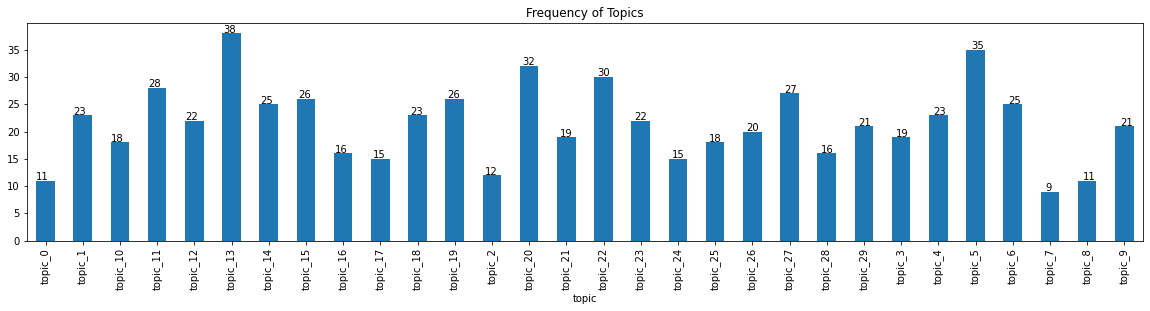

In [82]:
# fig = plt.figure(figsize=(10,4))
plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df_s.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


# Clustering using unsupervised learning to find most optimal clusters in these 30 topics

In [83]:
topics_all = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 30)]
topics_all.columns = topic_column_names
topics_all.to_csv("/Users/sdeshpande/Desktop/bioinformatices/Clinical_notes/topic_propensities.csv")

# print(topics_all.describe())
display(topics_all.head())

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,0.000501,0.000649,0.000499,0.000558,0.000566,0.000803,0.000592,0.000495,0.000508,0.000619,...,0.000705,0.000525,0.000625,0.000960,0.000544,0.000585,0.000557,0.000644,0.982002,0.000580
1,0.026987,0.035006,0.026909,0.030081,0.030512,0.043305,0.031925,0.026668,0.027388,0.033375,...,0.038018,0.028319,0.033720,0.051740,0.029325,0.031533,0.030029,0.034740,0.029746,0.031272
2,0.000418,0.000543,0.000417,0.000466,0.000473,0.000671,0.000495,0.000414,0.000425,0.000518,...,0.000590,0.000439,0.000523,0.000802,0.000455,0.000489,0.000466,0.046222,0.000461,0.000485
3,0.000501,0.000649,0.000499,0.000558,0.000566,0.982252,0.000592,0.000495,0.000508,0.000619,...,0.000705,0.000525,0.000626,0.000960,0.000544,0.000585,0.000557,0.000644,0.000552,0.000580
4,0.000824,0.001069,0.000822,0.000919,0.000932,0.001322,0.000975,0.000814,0.000836,0.001019,...,0.001161,0.000865,0.001030,0.001580,0.000895,0.000963,0.000917,0.001061,0.000908,0.000955


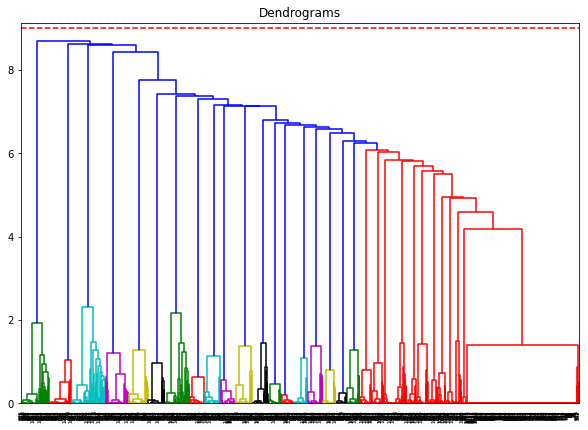

In [84]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = hierarchy.dendrogram(hierarchy.linkage(topics_all, method='ward'))
plt.axhline(y=9, color='r', linestyle='--')
plt.show()

In [85]:
from sklearn.cluster import AgglomerativeClustering
cluster_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster = cluster_model.fit_predict(topics_all).tolist()
# print(type(cluster))
topics_all["cluster"] = cluster

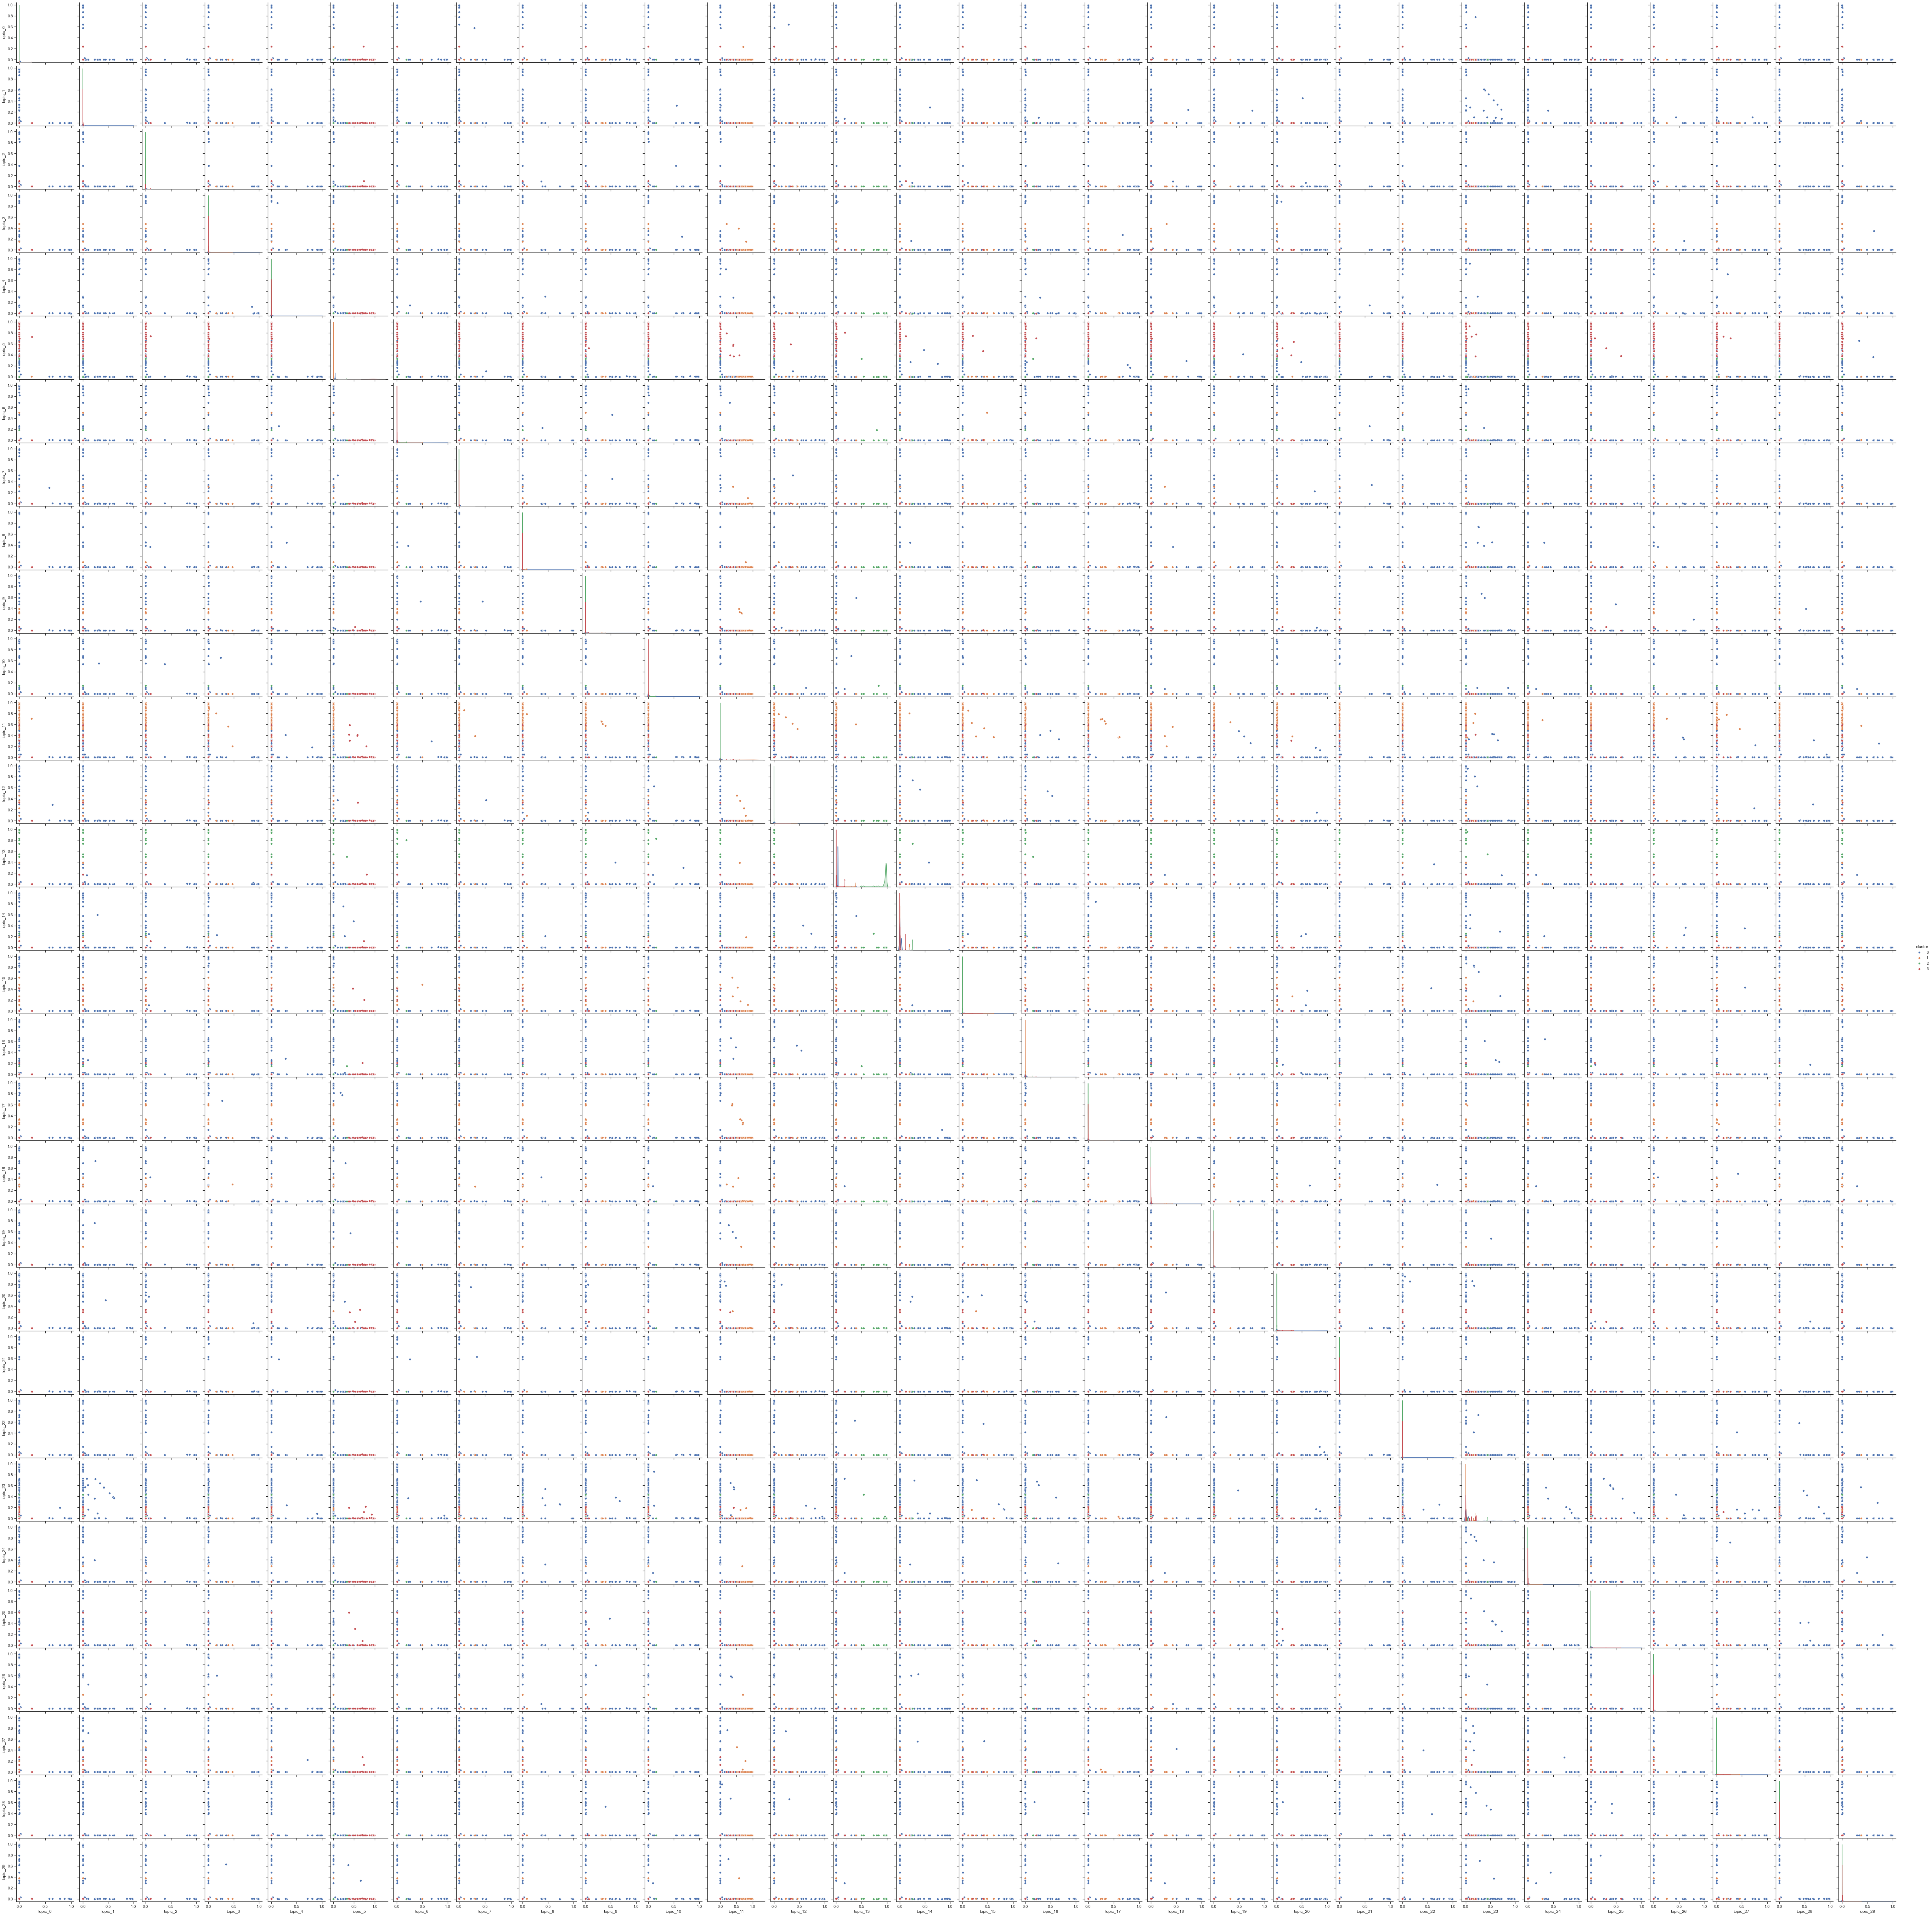

In [86]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(topics_all, hue="cluster")

In [87]:
df_for_h_visual = df_s
df_for_h_visual["cluster"] = topics_all["cluster"]
df_for_h_visual.drop(['propensity'], axis = 1, inplace=True)
df_for_h_visual.topic.fillna(value="Unknown", inplace=True)
df_for_h_visual.head()

,SUMMARY,topic,cluster
0,specialists center quijano.she denies stiffnes...,topic_28,0
1,,Unknown,0
2,history presenting complaint.female presents s...,Unknown,1
3,she had admissions.she had chf.echo shows hypo...,topic_5,3
4,female presenting complaint.complaint presenti...,Unknown,1


In [88]:
print(pd.unique(cluster))

[0 1 3 2]


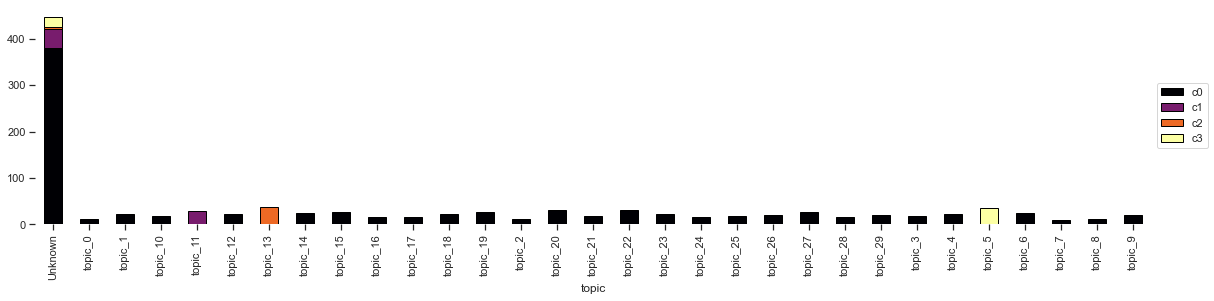

In [89]:
df_histo = df_for_h_visual.groupby(['topic','cluster']).count().reset_index()
df_histo = df_histo.pivot(index='topic', columns='cluster', values='SUMMARY')
df_histo.columns = ["c0", "c1", "c2", "c3"]

ax = df_histo.plot.bar(stacked=True,   colormap='inferno', edgecolor='black', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

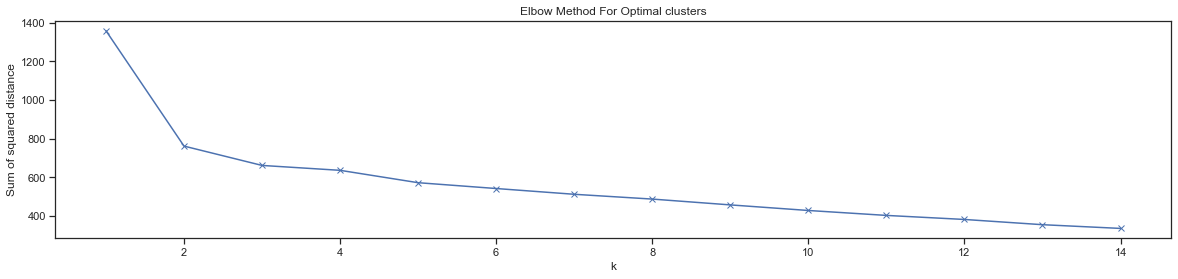

In [90]:
from sklearn.cluster import KMeans
Sum_of_squared_distance = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(topics_all)
    Sum_of_squared_distance.append(km.inertia_)
plt.plot(K, Sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal clusters')
plt.show()